<a href="https://colab.research.google.com/github/joanfco30/CocoaMoniliaDataSet/blob/main/CocoaMoniliaDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CocoaMoniliaDataSet: A cocoa pod dataset to detect and classify Monilia roreri in real conditions

In [1]:
from pathlib import Path
import shutil
import os, random, glob
import cv2 as cv
import matplotlib.pyplot as plt
import random
from pycocotools.coco import COCO
import json
import time
import pandas as pd
import numpy as np
%matplotlib inline

# Download the CocoaMoniliaDataset


In [2]:
 !wget -O dataset.zip "https://zenodo.org/records/17156052/files/CocoaMoniliaDataSet.zip?download=1"

--2025-11-24 18:50:22--  https://zenodo.org/records/17156052/files/CocoaMoniliaDataSet.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 188.185.43.153, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6187303002 (5.8G) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   5.76G  1.36MB/s    in 58m 58s 

2025-11-24 19:49:21 (1.67 MB/s) - ‘dataset.zip’ saved [6187303002/6187303002]



# Unzip the CocoaMoniliaDataset

In [3]:
!unzip dataset.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_001716_5.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002631_7.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002635_3.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002641_7.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_002643_9.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003921_874.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003925_198.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003927_582.png  
  inflating: CocoaMoniliaDataSet/mask_segmentation/SegmentationClassm1/IMG_20240229_003930_804.png  
  inflating: CocoaMoniliaDataSet/mask_se



```
CocoaMoniliaDataSet/
│
├── cocoapods_images/
│     ├── h0/
│     ├── m1/
│     ├── m2/
│     ├── m3/
│
│── COCO_annotations/
│     ├── instances_h0.json
│     ├── instances_m1.json
│     ├── instances_m2.json
│     ├── instances_m3.json
│
│── mask_segmentation/
│     ├── SegmentationClassh0/
│     ├── segmentationObjecth0/
│     ├── SegmentationClassm1/
│     ├── segmentationObjectm1/
│     ├── SegmentationClassm2/
│     ├── segmentationObjectm2/
│     ├── SegmentationClassm3/
│     ├── segmentationObjectm3/
│  
│── YOLO_annotations/
      ├── h0/
      ├── m1/
      ├── m2/
      ├── m3/


```



## Method to split the dataset YOLO Segmentation format





```
│── DataSet_split_seg/
│     ├─ images/
│     │    ├── train/
│     │    ├── test/
│     │    ├── val/
│     │
│     │
│     ├─ labels/
           ├── train/
           ├── test/
           ├── val/
```






## Annotatiom method

In [4]:
def get_label(cocoa_img_directory, label_img_directory, format_):

  for file in cocoa_img_directory.iterdir():
    for filename in os.listdir(file):
      if filename.endswith(".txt"):
          file_path = os.path.join(file, filename)

          os.remove(file_path)

  # Image directory dict
  img_dirs_dict = {d.name:
                  d for d in cocoa_img_directory.iterdir()
  }
  # Label jason files dict
  label_files = {
      f.stem.replace("instances_", ""): f
      for f in label_img_directory.iterdir()
      if f.is_file() and f.suffix == ".json"
  }
  for cls in sorted(img_dirs_dict.keys()):

    # === Input and output paths ===
      coco_json_path = str(label_files.get(cls))       # your JSON file
      output_dir = str(img_dirs_dict[cls])             # folder for YOLO txts
      #os.makedirs(output_dir, exist_ok=True)

      # === Load COCO annotations ===
      with open(coco_json_path, "r") as f:
          coco = json.load(f)

      # Create helper maps
      images = {img["id"]: img for img in coco["images"]}
      categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

      # === Iterate over annotations ===
      for ann in coco["annotations"]:
          image_id = ann["image_id"]
          cat_id = ann["category_id"]


          if format_ == "bbox":
            bbox  = ann[format_]

                    # COCO bbox = [x_min, y_min, width, height]
            x_min, y_min, w_box, h_box = bbox

            # Get image details
            image_info = images[image_id]
            img_w, img_h = image_info["width"], image_info["height"]

            # === Convert COCO → YOLO format ===
            # YOLO bbox = [cx, cy, w, h] normalized
            cx = (x_min + w_box / 2) / img_w
            cy = (y_min + h_box / 2) / img_h
            w_norm = w_box / img_w
            h_norm = h_box / img_h

            # YOLO class index starts at 0, but COCO starts at 1
            yolo_line = f"{cat_id - 1} {cx:.6f} {cy:.6f} {w_norm:.6f} {h_norm:.6f}"

            txt_path = os.path.join(output_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")

          if format_ == "segmentation":

            segmentation = ann[format_]

            # Get image details
            image_info = images[image_id]
            img_w, img_h = image_info["width"], image_info["height"]

            # Each annotation can have multiple segmentations (use all)
            yolo_lines = []
            if isinstance(segmentation, list):
                for seg in segmentation:
                    if len(seg) < 6:
                        continue  # invalid polygon
                    # Normalize coordinates
                    norm_coords = []
                    for i in range(0, len(seg), 2):
                        x = seg[i] / img_w
                        y = seg[i + 1] / img_h
                        norm_coords.append(f"{x:.6f} {y:.6f}")

                    line = f"{cat_id - 1} " + " ".join(norm_coords)  # YOLO class ids start at 0
                    yolo_lines.append(line)

            # === Write output file ===
            txt_path = os.path.join(output_dir, os.path.splitext(image_info["file_name"])[0] + ".txt")


          with open(txt_path, "a") as f:
            if format_ == "segmentation":
              for line in yolo_lines:
                  f.write(line + "\n")

            if format_ == "bbox":
              f.write(yolo_line + "\n")



      print(f"✅ Conversion complete! YOLO txt labels saved to: {output_dir}")

In [5]:
#COCOA_IMAGE_DIR = Path("/content/CocoaMoniliaDataSet/cocoapods_images")
#ANNOTATION_DIR = Path("/content/CocoaMoniliaDataSet/COCO_annotations")
#FORMAT = "segmentation"

#get_label(cocoa_img_directory=COCOA_IMAGE_DIR, label_img_directory=ANNOTATION_DIR, format_=FORMAT)


In [6]:
#COCOA_IMAGE_DIR = Path("/content/CocoaMoniliaDataSet/cocoapods_images")
#ANNOTATION_DIR = Path("/content/CocoaMoniliaDataSet/COCO_annotations")
#FORMAT = "bbox"

#get_label(cocoa_img_directory=COCOA_IMAGE_DIR, label_img_directory=ANNOTATION_DIR, format_=FORMAT)

## Method to split the dataeset

In [7]:
def split_datset(data_root, work_dir):
  print(data_root, work_dir)
  # Create YOLO structure to separate the labels and the images in each directory
  for split in ["train", "val", "test"]:
      (work_dir / f"images/{split}").mkdir(parents=True, exist_ok=True)
      (work_dir / f"labels/{split}").mkdir(parents=True, exist_ok=True)

  img_exts = {".jpg", ".jpeg", ".png"}
  pairs = []

  for img_path in data_root.rglob("*"):
      if img_path.suffix.lower() in img_exts:
          label_path = img_path.with_suffix(".txt")
          if label_path.exists():
              pairs.append((img_path, label_path))

  print(f"Found {len(pairs)} image-label pairs.")

  # Shuffle & split
  random.shuffle(pairs)
  n = len(pairs)
  n_train = int(0.8 * n)
  n_val = int(0.1 * n)
  splits = {
      "train": pairs[:n_train],
      "val": pairs[n_train:n_train+n_val],
      "test": pairs[n_train+n_val:]
  }
  # Copy files into YOLO structure
  for split, items in splits.items():
      for img, lbl in items:
          shutil.copy2(img, work_dir / f"images/{split}/{img.name}")
          shutil.copy2(lbl, work_dir / f"labels/{split}/{lbl.name}")

  print({k: len(v) for k,v in splits.items()})

## Method to split the dataset YOLO format

```
│── DataSet_split_seg/
│     ├─ images/
│     │    ├── train/
│     │    ├── test/
│     │    ├── val/
│     │
│     │
│     ├─ labels/
           ├── train/
           ├── test/
           ├── val/
```

In [8]:
# We create a subdirectory to split the dataset
#DATA_ROOT = Path("/content/CocoaMoniliaDataSet/cocoapods_images")

#In the output directory, we split the dataset into train, validation, and test
WORK_DIR = Path("DataSet_split_seg")


COCOA_IMAGE_DIR = Path("/content/CocoaMoniliaDataSet/cocoapods_images")
ANNOTATION_DIR = Path("/content/CocoaMoniliaDataSet/COCO_annotations")
FORMAT = "segmentation"

get_label(cocoa_img_directory=COCOA_IMAGE_DIR, label_img_directory=ANNOTATION_DIR, format_=FORMAT)

split_datset(data_root = COCOA_IMAGE_DIR, work_dir = WORK_DIR)


✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/h0
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m1
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m2
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m3
/content/CocoaMoniliaDataSet/cocoapods_images DataSet_split_seg
Found 1950 image-label pairs.
{'train': 1560, 'val': 195, 'test': 195}


## Method to split the dataset YOLO format

```
│── DataSet_split_bbox/
│     ├─ images/
│     │    ├── train/
│     │    ├── test/
│     │    ├── val/
│     │
│     │
│     ├─ labels/
           ├── train/
           ├── test/
           ├── val/
```

In [9]:
WORK_DIR = Path("DataSet_split_bbox")


COCOA_IMAGE_DIR = Path("/content/CocoaMoniliaDataSet/cocoapods_images")
ANNOTATION_DIR = Path("/content/CocoaMoniliaDataSet/COCO_annotations")
FORMAT = "bbox"

get_label(cocoa_img_directory=COCOA_IMAGE_DIR, label_img_directory=ANNOTATION_DIR, format_=FORMAT)

split_datset(data_root = COCOA_IMAGE_DIR, work_dir = WORK_DIR)

✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/h0
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m1
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m2
✅ Conversion complete! YOLO txt labels saved to: /content/CocoaMoniliaDataSet/cocoapods_images/m3
/content/CocoaMoniliaDataSet/cocoapods_images DataSet_split_bbox
Found 1950 image-label pairs.
{'train': 1560, 'val': 195, 'test': 195}


## Method to create a Yolo object detection format




In [10]:
#!zip -r /content/CocoaMoniliaDataSet_split.zip /content/CocoaMoniliaDataSet_split

In [11]:
#from google.colab import files
#files.download("/content/file.zip")

In [12]:
#!zip -r /content/DataSet_split_seg.zip /content/CocoaMoniliaDataSet/DataSet_split_seg

In [13]:
#from google.colab import files
#files.download("/content/DataSet_split_seg.zip")

In [14]:


#!zip -r /content/DataSet_split_bbox.zip /content/CocoaMoniliaDataSet/DataSet_split_bbox


#from google.colab import files
#files.download("/content/DataSet_split_bbox.zip")

In [15]:
#images_dir = "/content/DataSet_split_seg/images/train"                # Folder with your .jpg images
#labels_dir = "/content/DataSet_split_seg/labels/train"       # Folder with your YOLO segmentation .txt files
#visualize_one_yolo_segmentation(images_dir, labels_dir)

In [16]:
#images_dir = "/content/DataSet_split_seg/images/test"                # Folder with your .jpg images
#labels_dir = "/content/DataSet_split_seg/labels/test"       # Folder with your YOLO segmentation .txt files
#visualize_one_yolo_segmentation(images_dir, labels_dir)

In [17]:
#images_dir = "/content/DataSet_split_seg/images/val"                # Folder with your .jpg images
#labels_dir = "/content/DataSet_split_seg/labels/val"       # Folder with your YOLO segmentation .txt files
#visualize_one_yolo_segmentation(images_dir, labels_dir)

In [18]:
path_image = '/content/DataSet_split_bbox/images'
path_label = '/content/DataSet_split_bbox/labels'

def choice_one():
    classes = os.listdir(path_image)
    random_name_class = random.choice(classes)
    path_dir_ima = os.path.join(path_image, random_name_class)
    list_name_files = os.listdir(path_dir_ima)
    name_file = random.choice(list_name_files)[:-4]
    return os.path.join(path_image, random_name_class,name_file)

def create_paths(base_image_path):
    p = Path(base_image_path)
    split = p.parent.name
    filename = p.name

    img_path = Path(path_image) / split / f"{filename}.jpg"
    lbl_path = Path(path_label) / split / f"{filename}.txt"

    return str(img_path), str(lbl_path)

def images_selected(n):
    array_file_image_selected = []
    array_file_label_selected = []
    for i in range(n):
        file_image_selected = choice_one()
        img_path, label_path = create_paths(file_image_selected)

        array_file_image_selected.append(img_path)
        array_file_label_selected.append(label_path)

    return array_file_image_selected,array_file_label_selected


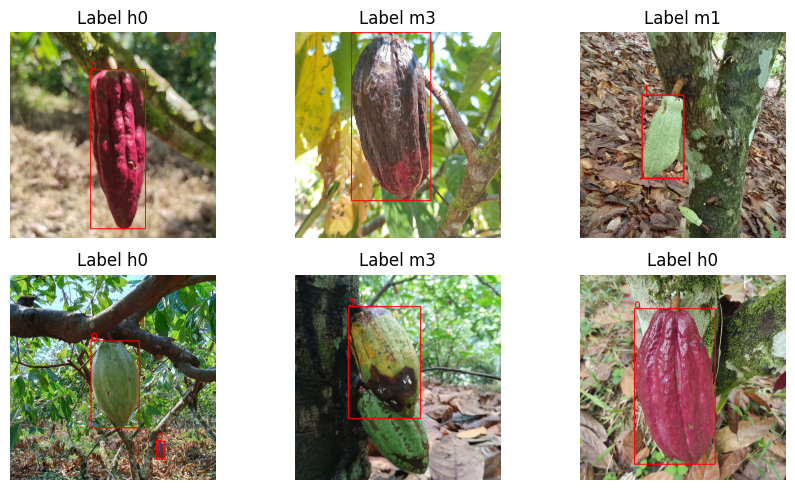

In [19]:
dict_cat = {0: "h0",
            1: "m1",
            2: "m2",
            3: "m3",
            4: "m4"
}

# Read labels using format YoLo, the format is presented as follows: X, Y center, and the width and height of the box
plt.figure(figsize=(9, 5))
image_files, label_files = images_selected(6)
j = 0
for i,l in zip(image_files, label_files):
    image = cv.imread(i)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # convertir a RGB para matplotlib
    h, w, _ = image.shape

    with open(l, "r") as f:
        lines = f.readlines()

    # Draw a bounding box
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, box_w, box_h = map(float, parts[1:])

        # Convertir de YOLO (normalizado) → píxeles
        # Convert YoLo format normalized to pixels
        x_center, y_center = x_center * w, y_center * h
        box_w, box_h = box_w * w, box_h * h

        # calculate the corner coordinates
        x1 = int(x_center - box_w / 2)
        y1 = int(y_center - box_h / 2)
        x2 = int(x_center + box_w / 2)
        y2 = int(y_center + box_h / 2)

        # OpenCV methods to draw a rectangle
        cv.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 15)  # azul
        cv.putText(image, str(class_id), (x1, y1 - 10),
                    cv.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 15)
    # Show the image using pypo
    #plt.figure(figsize=(5, 5))

    plt.subplot(2, 3, j + 1)
    j = j + 1
    plt.title(f"Label {dict_cat[class_id]}")

    plt.imshow(image)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [20]:
path_image = '/content/DataSet_split_seg/images'
path_label = '/content/DataSet_split_seg/labels'

def choice_one():
    classes = os.listdir(path_image)
    random_name_class = random.choice(classes)
    path_dir_ima = os.path.join(path_image, random_name_class)
    list_name_files = os.listdir(path_dir_ima)
    name_file = random.choice(list_name_files)[:-4]
    return os.path.join(path_image, random_name_class,name_file)



def create_paths(base_image_path):
    p = Path(base_image_path)              # example: /images/val/1728667861476
    split = p.parent.name                  # "val"
    filename = p.name                      # "1728667861476"

    img_path = Path(path_image) / split / f"{filename}.jpg"
    lbl_path = Path(path_label) / split / f"{filename}.txt"

    return str(img_path), str(lbl_path)

def images_selected(n):
    array_file_image_selected = []
    array_file_label_selected = []
    for i in range(n):
        file_image_selected = choice_one()
        img_path, label_path = create_paths(file_image_selected)

        array_file_image_selected.append(img_path)
        array_file_label_selected.append(label_path)

    return array_file_image_selected,array_file_label_selected

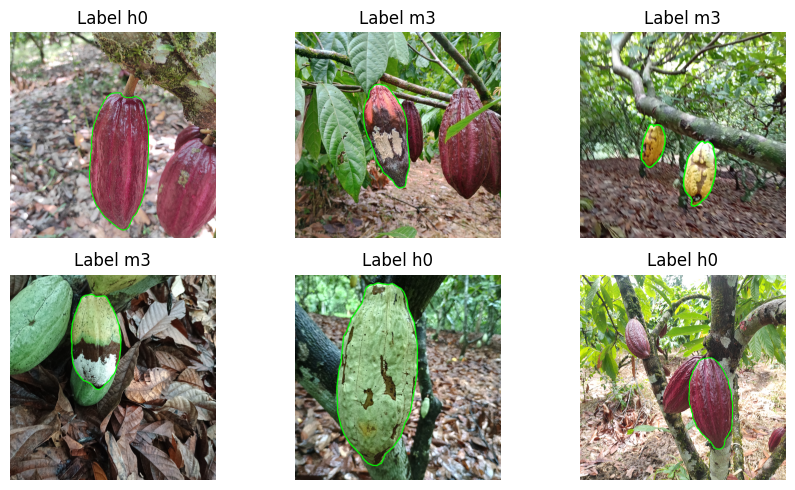

In [21]:
dict_cat = {0: "h0",
            1: "m1",
            2: "m2",
            3: "m3",
            4: "m4"
}

# Read labels using format YoLo, the format is presented as follows: X, Y center, and the width and height of the box
plt.figure(figsize=(9, 5))
image_files, label_files = images_selected(6)
j = 0
for i,l in zip(image_files, label_files):
    image = cv.imread(i)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # convertir a RGB para matplotlib
    h, w, _ = image.shape

    with open(l, "r") as f:
      for line in f:
        parts = line.strip().split()
        if len(parts) < 7:
          continue

        class_id = int(parts[0])
        coords = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(-1, 2)

        # Scale polygon to resized image
        coords[:, 0] *= w
        coords[:, 1] *= h
        pts = coords.astype(np.int32)


            # ---- Draw segmentation polygon ----
        cv.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=15)
                        # Label
            # ---- Add label ----

    # Show the image using pypo
    #plt.figure(figsize=(5, 5))

    plt.subplot(2, 3, j + 1)
    j = j + 1
    plt.title(f"Label {dict_cat[class_id]}")

    plt.imshow(image)
    plt.axis("off")
plt.tight_layout()
plt.show()

## YAML file configuration

YAML file defines the dataset path and class names. The label files, according to the task, contain normalized bounding box coordinates with their respective class, or the polygon coordinates of its mask.

In [23]:
WORK_DIR = Path("/content/DataSet_split_bbox")

yaml_conf_file = f"""
path: {WORK_DIR}
train: images/train
val: images/val
test: images/test
names:
  0: h0
  1: m1
  2: m2
  3: m3
"""

(WORK_DIR / "yolovx.yaml").write_text(yaml_conf_file)
print((WORK_DIR / "yolovx.yaml").read_text())


path: /content/DataSet_split_bbox
train: images/train
val: images/val
test: images/test
names:
  0: h0
  1: m1
  2: m2
  3: m3

